# Data Understanding
Este notebook refere-se à etapa de entendimento dos dados do [Quati Dataset](https://huggingface.co/datasets/unicamp-dl/quati) utilizado no projeto do **RAG-BR**, contemplando os passos:
- Coleta dos dados
- Limpeza inicial
- Análise exploratória

Ao final, os dados pré-processados são salvos em formato `parquet` para as etapas futuras.

### **Conclusões sobre o entendimento dos dados**
O Quati Dataset atende os requisitos básicos para o projeto RAG-BR, apresentando características favoráveis para a construção de um sistema de recuperação e geração de respostas, porém apresenta pouquíssima quantidade de dados relevantes para treinamento de um modelo de reranking neural.

Os principais pontos observados foram:
- O dataset **possui um corpus relativamente grande**, com pelo menos 1 milhão de documentos, o que é positivo para a etapa de recuperação inicial.
- Possui uma **quantidade razoável de queries** (200 queries), o que pode ser suficiente para a etapa de avaliação do sistema.
- Os textos dos documentos e das queries apresentam uma boa variação de tamanho, o que é positivo para a robustez do sistema, apesar de ainda existir ruídos principalmente nos documentos.
- A **quantidade de qrels** (relações entre queries e documentos relevantes) é **baixíssima** (menos de 2000, das quais mais de 50% são irrelevantes), evidenciando o maior desafio do dataset: a escassez de dados relevantes para treinamento de modelos de reranking neural.
- A análise de overlap léxico revelou uma distribuição razoável de palavras em comum entre queries e documentos (overlap léxico médio na faixa de 0.5 a 0.7), indicando que modelos baseados em TF-IDF/BM25 também podem apresentar um desempenho satisfatório na etapa de recuperação inicial.

Resumidamente, o **Quati Dataset apresenta características favoráveis para a construção do sistema RAG-BR**, especialmente na etapa de recuperação inicial, e é útil para o problema de negócio proposto. No entanto, a escassez de dados relevantes para treinamento de modelos de reranking neural representa um desafio significativo, tornando **necessária a utilização de um outro dataset suplementar** para essa etapa específica do sistema, que será abordado posteriormente.

----

## Importações e instalações

> **Obs.:** A versão mais recente da biblioteca `datasets` (>4.0.0) do HuggingFace removeu o suporte para o carregamento de conjuntos de dados que dependem de scripts Python remotos por razões de segurança. O dataset Quati ainda utiliza um desses scripts (quati.py) para processar e carregar os dados. Desta forma, foi necessário instalar uma versão anterior da biblioteca para carregar os dados do dataset (baixar os dados diretamente do repositório seria outra alternativa).

In [1]:
# Instalações
!pip install "datasets<4.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
# Imports
# Utils
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Manipulação de dados
import pandas as pd
from datasets import load_dataset
pd.set_option("display.width", 120)

# Visualização gráfica
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set_palette('mako')
sns.color_palette('mako', as_cmap=True)

# NLP (limpeza e processamento textual básico)
import re
import unicodedata

## Coleta dos dados
O dataset encontra-se disponível através do HuggingFace e está atualmente disponível em duas versões: uma com 1 milhão de passagens (`quati_1M_passages`) e outra maior, com 10 milhões de passagens (`quati_10M_passages`). Por questões de praticidade e limtação computacional, foi utilizado o `quati_1M_passages`.

O dataset possui três tabelas:
- `Passages`: Tabela contendo os documentos para Recuperação de Informação.
- `Qrels`: Tabela contendo as relações e os scores (de 0 a 3) entre as consultas e os documentos.
- `Topics`: Tabela contendo consultas/perguntas para corresponder com os documentos.

### `passages` - Tabela de documentos/passagens

In [3]:
# Load passages
passages_dataset = load_dataset("unicamp-dl/quati", "quati_1M_passages", trust_remote_code=True)["quati_1M_passages"]

passages_dataset

README.md: 0.00B [00:00, ?B/s]

quati.py: 0.00B [00:00, ?B/s]

quati_1M.tsv:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Generating quati_1M_passages split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['passage_id', 'passage'],
    num_rows: 1000000
})

In [4]:
passages_dataset[:3]

{'passage_id': ['clueweb22-pt0000-00-00003_1',
  'clueweb22-pt0000-00-00003_2',
  'clueweb22-pt0000-00-00003_3'],
 'passage': ['Se você precisar de ajuda, visite o website nacional sobre a COVID-19 ou ligue para a linha de apoio à COVID-19 808 24 24 24 Perguntas mais frequentes Posso viajar entre Sintra e Cascais? Quais são as restrições de viagem em Cascais? Qual o número de telefone de apoio para a COVID 19 em Cascais? Preciso utilizar máscara facial no transporte público em Cascais? A prática do distanciamento social é compulsória em Cascais? O que eu devo fazer caso apresente sintomas da COVID-19 quando chegar em Cascais? Última atualização: 25 Abr 2022 Aplicam-se exceções, para detalhes completos: European Union. Estamos trabalhando ininterruptamente para lhe trazer as últimas informações de viagem relacionadas à COVID-19. Esta informação é compilada a partir de fontes oficiais. Ao melhor de nosso conhecimento, está correta de acordo com a última atualização. Visite Avisos de Viag

### `qrels` - Tabela de correspondência entre consultas e documentos

In [5]:
# Load qrels
qrels_dataset = load_dataset("unicamp-dl/quati", "quati_1M_qrels", trust_remote_code=True)["quati_1M_qrels"]

qrels_dataset

quati_1M_qrels.txt: 0.00B [00:00, ?B/s]

Generating quati_1M_qrels split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['query_id', 'passage_id', 'score'],
    num_rows: 1933
})

In [6]:
qrels_dataset[:5]

{'query_id': [1, 1, 1, 1, 1],
 'passage_id': ['clueweb22-pt0000-78-09747_0',
  'clueweb22-pt0000-96-07278_111',
  'clueweb22-pt0001-85-06153_3',
  'clueweb22-pt0000-64-06285_35',
  'clueweb22-pt0000-87-13049_0'],
 'score': [1, 1, 1, 2, 0]}

### `topics` - Tabela de consultas/tópicos

In [7]:
# Load topics
topics_dataset = load_dataset("unicamp-dl/quati", "quati_all_topics", trust_remote_code=True)["quati_all_topics"]

topics_dataset

quati_all_topics.tsv: 0.00B [00:00, ?B/s]

Generating quati_all_topics split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['query_id', 'query'],
    num_rows: 200
})

In [8]:
topics_dataset[:5]

{'query_id': [0, 1, 2, 3, 4],
 'query': ['Qual a maior característica da flora brasileira?',
  'Qual a maior característica da fauna brasileira?',
  'Por que os países Guiana e Suriname não são filiados a Conmebol?',
  'Por que a Bolívia tem duas capitais?',
  'Qual o que significa decolonialidade?']}

## Limpeza inicial e verificações
A limpeza inicial aqui aplicada consiste na eliminação de ruídos e padronização na formatação dos textos que podem distorcer a análise textual. Para isso, foram utilizadas de técnicas básicas de **Processamento de Linguagem Natural** (NLP) através expressões regulares.

Após a limpeza inicial, foi realizada uma verificação do conjunto de dados para observar a ocorrência de textos vazios e (quase) duplicados para garantir a consistência e qualidade dos dados.

As ações necessárias aqui aplicadas são essenciais para que a análise exploratória apresente resultados mais coerentes mais a frente.

In [9]:
# Clean text function
def clean_text(text: str) -> str:
    """
    Realiza limpeza de ruídos e padroniza a formatação do textual através de regex.
    Remove:
        - Texto em HTML
        - Múltiplos espaços
        - Caractéres estranhos

    Params:
        text (str): Texto com ruídos
    Returns:
        str: Texto formatado e limpo
    """
    if text is None:
        return ""

    clean_text = unicodedata.normalize("NFKC", text)

    # Remove HTML
    clean_text = re.sub(r"<[^>]+>", " ", clean_text)

    # Remove multiple spaces
    clean_text = re.sub(r"\s+", " ", clean_text)

    # Remove strange characters
    clean_text = clean_text.replace("\x00", " ")

    return clean_text.strip().lower()

In [10]:
# Applying text cleanup on passages
def clean_passages(batch):
    batch["clean_passage"] = [clean_text(passage) for passage in batch["passage"]]
    return batch

passages_dataset = passages_dataset.map(
    clean_passages,
    batched=True,
    batch_size=100_000,
    num_proc=os.cpu_count()
)

passages_dataset.select_columns(["passage", "clean_passage"])[:3]

Map (num_proc=2):   0%|          | 0/1000000 [00:00<?, ? examples/s]

{'passage': ['Se você precisar de ajuda, visite o website nacional sobre a COVID-19 ou ligue para a linha de apoio à COVID-19 808 24 24 24 Perguntas mais frequentes Posso viajar entre Sintra e Cascais? Quais são as restrições de viagem em Cascais? Qual o número de telefone de apoio para a COVID 19 em Cascais? Preciso utilizar máscara facial no transporte público em Cascais? A prática do distanciamento social é compulsória em Cascais? O que eu devo fazer caso apresente sintomas da COVID-19 quando chegar em Cascais? Última atualização: 25 Abr 2022 Aplicam-se exceções, para detalhes completos: European Union. Estamos trabalhando ininterruptamente para lhe trazer as últimas informações de viagem relacionadas à COVID-19. Esta informação é compilada a partir de fontes oficiais. Ao melhor de nosso conhecimento, está correta de acordo com a última atualização. Visite Avisos de Viagem Rome2rio para ajuda geral. Perguntas & Respostas Qual a maneira mais econômica de ir de Sintra para Cascais? Qu

In [11]:
# Applying text cleanup on topics
def clean_topics(batch):
    batch["clean_query"] = [clean_text(query) for query in batch["query"]]
    return batch

topics_dataset = topics_dataset.map(
    clean_topics,
    batched=True,
    batch_size=100_000,
    num_proc=os.cpu_count()
)

topics_dataset.select_columns(["query", "clean_query"])[:3]

Map (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

{'query': ['Qual a maior característica da flora brasileira?',
  'Qual a maior característica da fauna brasileira?',
  'Por que os países Guiana e Suriname não são filiados a Conmebol?'],
 'clean_query': ['qual a maior característica da flora brasileira?',
  'qual a maior característica da fauna brasileira?',
  'por que os países guiana e suriname não são filiados a conmebol?']}

### Verificação em `passages`

In [12]:
# Convert dataset into pandas dataframe
passages_df = passages_dataset.to_pandas()

passages_df.head()

,passage_id,passage,clean_passage
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na...","se você precisar de ajuda, visite o website na..."
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ...","""o casino estoril fica localizado no estoril, ..."
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...


In [13]:
# Display dataset info
passages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   passage_id     1000000 non-null  object
 1   passage        1000000 non-null  object
 2   clean_passage  1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


In [14]:
# Verify empty strings on passages
null_passages = passages_df[passages_df["clean_passage"] == ""]

if len(null_passages) == 0:
    print("Sem documentos vazios.")
else:
    print(f"Quantidade de documentos vazios: {len(null_passages)}")
    null_passages.head()

Sem documentos vazios.


In [15]:
# Verify duplicates or almost-duplicates passages
passages_df["hash"] = passages_df["clean_passage"].apply(lambda x: hash(x))
passages_df["hash"].value_counts().head()

,count
hash,
231506311214161699,5
8102532024796603670,4
6398593541520837367,4
-2854199983350766675,4
9060740357547619716,3


### Verificação em `topics`

In [16]:
# Convert dataset into a dataframe
topics_df = topics_dataset.to_pandas()

topics_df.head()

,query_id,query,clean_query
0,0,Qual a maior característica da flora brasileira?,qual a maior característica da flora brasileira?
1,1,Qual a maior característica da fauna brasileira?,qual a maior característica da fauna brasileira?
2,2,Por que os países Guiana e Suriname não são fi...,por que os países guiana e suriname não são fi...
3,3,Por que a Bolívia tem duas capitais?,por que a bolívia tem duas capitais?
4,4,Qual o que significa decolonialidade?,qual o que significa decolonialidade?


In [17]:
# Display dataset info
topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_id     200 non-null    int32 
 1   query        200 non-null    object
 2   clean_query  200 non-null    object
dtypes: int32(1), object(2)
memory usage: 4.0+ KB


In [18]:
# Verify empty strings on queries
null_topics = topics_df[topics_df["clean_query"] == ""]
if len(null_topics) == 0:
    print("Sem consultas vazias.")
else:
    print(f"{len(null_topics)} consultas vazias encontradas.")
    null_topics.head()

Sem consultas vazias.


In [19]:
# Verify duplicates or almost-duplicates queries
topics_df["hash"] = topics_df["clean_query"].apply(lambda x: hash(x))
topics_df["hash"].value_counts().head()

,count
hash,
-3715575733720293611,1
8935465591563411859,1
4676032334993132390,1
7837745354635987343,1
-7619139708780009961,1


### Verificação em `qrels`

In [20]:
# Convert dataset into a dataframe
qrels_df = qrels_dataset.to_pandas()

qrels_df.head()

,query_id,passage_id,score
0,1,clueweb22-pt0000-78-09747_0,1
1,1,clueweb22-pt0000-96-07278_111,1
2,1,clueweb22-pt0001-85-06153_3,1
3,1,clueweb22-pt0000-64-06285_35,2
4,1,clueweb22-pt0000-87-13049_0,0


In [21]:
# Display dataset info
qrels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    1933 non-null   int32 
 1   passage_id  1933 non-null   object
 2   score       1933 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 30.3+ KB


In [22]:
# Count scores
qrels_df["score"].value_counts()

,count
score,
0,1039
1,388
2,318
3,188


## Análise exploratória

### Distribuição do tamanho dos textos
Utilizado para avaliar a quantidade de palavras em cada documento. Essa análise é útil para:
- Entender se o modelo deve ser robusto a micro-queries; observa-se que as queries tem entre 4 a 16 palavras.
- Identificar a proporção de documentos _heavy tails_, muito longos, observa-se que os documentos possuem entre 50 a 300 palavras.
- Avaliar a quantidade de tokens que podem ser necessários passar via LLM.

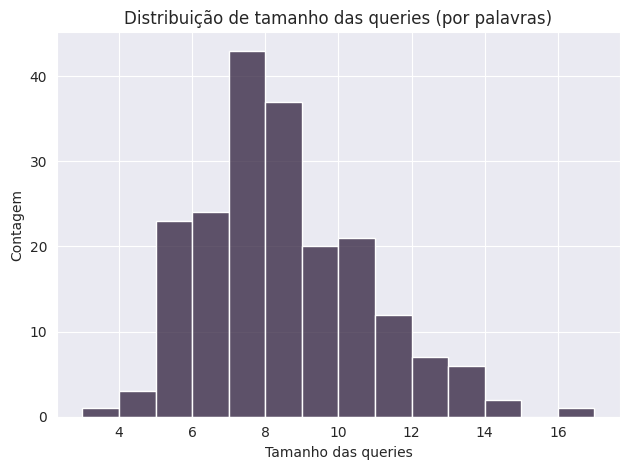

In [23]:
# Plot length of queries distribution
topics_df["len"] = topics_df["clean_query"].str.split().apply(len)

ax = sns.histplot(topics_df["len"])
ax.set_title("Distribuição de tamanho das queries (por palavras)")
ax.set_xlabel("Tamanho das queries")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

In [24]:
# Display queries too short
topics_df.loc[topics_df["len"] < 2, ["query", "clean_query", "len"]].head()

,query,clean_query,len


In [25]:
# Display queries too large
topics_df.loc[topics_df["len"] > 40, ["query", "clean_query", "len"]].head()

,query,clean_query,len


> Obs.: Foram encontrados certos obstáculos para calcular o tamanho dos documentos através do split dos documentos nos espaços, o que causou um overload na memória RAM. Desta forma, para definir o tamanho dos documentos, foi calculado a quantidade de espaços presentes no documento.

In [26]:
# Get the length of the documents more memory-efficiently
# Count spaces and add 1 for each word. Handle empty strings separately.
passages_df["len"] = passages_df["clean_passage"].str.count(' ') + 1
# For truly empty strings, the word count should be 0, not 1
passages_df.loc[passages_df["clean_passage"] == "", "len"] = 0

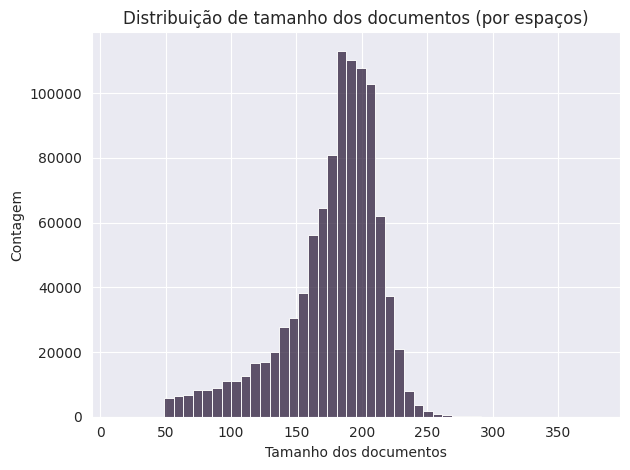

In [27]:
# Plot length of passages distribution
ax = sns.histplot(passages_df["len"], bins=50)
ax.set_title("Distribuição de tamanho dos documentos (por espaços)")
ax.set_xlabel("Tamanho dos documentos")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

In [28]:
# Verify the documents too large (outliers)
# Calculate the 99th percentile for document length
length_99th_percentile = passages_df["len"].quantile(0.99)

# Filter for documents with length above the 99th percentile and sort them in descending order
outlier_passages = passages_df[passages_df["len"] > length_99th_percentile].sort_values(by="len", ascending=False)

# Display the top 10 longest outlier documents
print(f"Quantidade de documentos acima do quantil 99: {len(outlier_passages)}")
print(f"Tamanho do menor documento acima do quantil 99: {min(outlier_passages["len"])}")
outlier_passages.head(10)[["len", "passage", "clean_passage"]]

Quantidade de documentos acima do quantil 99: 9752
Tamanho do menor documento acima do quantil 99: 237


,len,passage,clean_passage
278,379,"""¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯...",""" ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ̄ ..."
641280,350,O que eu pedir Ele me d F Fm Em Os inimigos qu...,o que eu pedir ele me d f fm em os inimigos qu...
641282,345,Por esta compreenso Bm D Est neste caminho D A...,por esta compreenso bm d est neste caminho d a...
641281,342,Estou fazendo o meu jardim C G rezar e por em ...,estou fazendo o meu jardim c g rezar e por em ...
641283,335,O Daime o Daime C G O Mestre de todos ensinos ...,o daime o daime c g o mestre de todos ensinos ...
641285,333,"Para o meu Mestre vir c C Em Todos tm, todos t...","para o meu mestre vir c c em todos tm, todos t..."
957277,331,Back to top C Cartas de Louis Claude de Saint-...,back to top c cartas de louis claude de saint-...
363809,324,Porque éramos apenas crianças quando nos apaix...,porque éramos apenas crianças quando nos apaix...
95040,323,Uma estreita faixa da população latino-america...,uma estreita faixa da população latino-america...
641284,321,Para ser eternamente E A Para Deus lhe atender...,para ser eternamente e a para deus lhe atender...


### Relação de documentos com queries
Nesta análise, exploramos a relação entre as queries e os documentos. Para isso, foram visualizados:
- Quantidade de documentos com queries
- Quantidade de queries com documentos
- Distribuição de documentos por query
- Distribuição de scores de relevância


A partir das análises, foi possível verificar que:
- A maioria dos documentos não possuem uma query; existem 998.104 documentos sem consulta.
- Das 200 queries disponíveis no conjunto de dados de queries, apenas 50 possuem alguma relação (`qrel`) com os documentos; ou seja, 150 consultas sem relação com documentos.
- Em relação à distribuição das queries relacionadas com documentos, existem entre 20 e 60 documentos por query
- A distribuição de scores (relação query X passage) está distribuída de 0 a 3, sendo a maioria deles (1039 de 1933 scores) estão valoradas como 0, ou seja, a query não tem relevância com o documento relacionado.

Isso diminui, e muito, a quantidade de dados úteis para treinamento do reranker, visto que a maioria dos documentos e queries ainda não possuem uma relação de score. Além disso, a distribuição de scores aponta que a maioria das consultas possuem 0 de relevância para os documentos relacionados.

In [29]:
# Verify how much documents without a query
non_query_docs = passages_df[~passages_df['passage_id'].isin(qrels_df['passage_id'])]

print(f"Quantidade de documentos sem query: {len(non_query_docs)}.")
non_query_docs.head()

Quantidade de documentos sem query: 998104.


,passage_id,passage,clean_passage,hash,len
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na...","se você precisar de ajuda, visite o website na...",-7859219315396982254,205
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...,-5161065263962965672,197
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ...","""o casino estoril fica localizado no estoril, ...",-942023248685789238,142
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...,-4570883003981616421,164
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...,2486104088832779096,187


In [30]:
# Verify how much queries without documents
non_doc_queries = topics_df[~topics_df['query_id'].isin(qrels_df['query_id'])]

print(f"Quantidade de queries sem documentos: {len(non_doc_queries)}.")
non_query_docs.head()

Quantidade de queries sem documentos: 150.


,passage_id,passage,clean_passage,hash,len
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na...","se você precisar de ajuda, visite o website na...",-7859219315396982254,205
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...,-5161065263962965672,197
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ...","""o casino estoril fica localizado no estoril, ...",-942023248685789238,142
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...,-4570883003981616421,164
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...,2486104088832779096,187


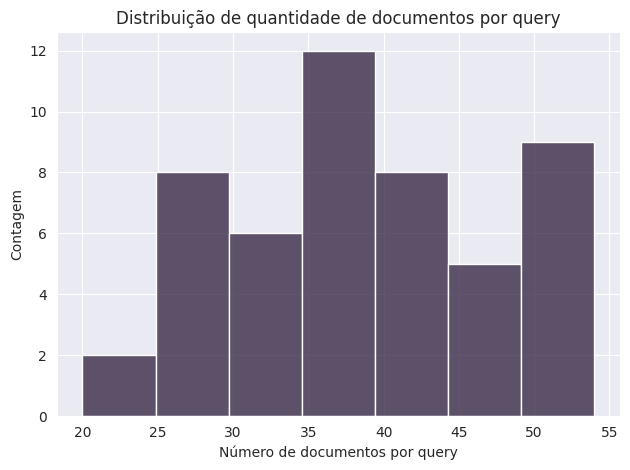

,passage_id
count,50.000000
mean,38.660000
std,8.968448
min,20.000000
25%,31.500000
50%,38.500000
75%,45.750000
max,54.000000


In [31]:
# Count document relevance score by query
rels_count = qrels_df.groupby("query_id")["passage_id"].count()

ax = sns.histplot(rels_count)
ax.set_title("Distribuição de quantidade de documentos por query")
ax.set_xlabel("Número de documentos por query")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

rels_count.describe()

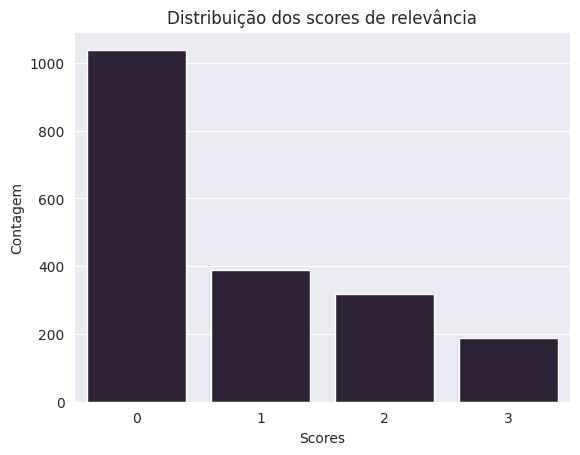

In [32]:
# Plot distribuition of scores
ax = sns.countplot(data=qrels_df, x="score")
ax.set_title("Distribuição de scores de relevância")
ax.set_xlabel("Scores")
ax.set_ylabel("Contagem")

plt.title("Distribuição dos scores de relevância")
plt.show()

### Amostras qualitativas
Abaixo, apresentamos uma amostra qualitativa dos dados. A partir de uma query filtrada e randomicamente selecionada, apresentamos a consulta e alguns dos documentos relacionados.

Desta forma, é possível avaliar qualitativamente os textos das consultas e dos documentos, bem como interpretar melhor o score de relevância (relação entre as consultas e os documentos).

In [33]:
# Function to display documents X query sample
def display_sample(score_filter: int):
    """
    Displays a query sample with its documents (up to 10).

    Params:
        score_filter (int): Score to filter the sample
    """
    # Get randomly a query with the score filter
    sample_q = random.choice(qrels_df.loc[qrels_df["score"] == score_filter, "query_id"].tolist())
    sample = qrels_df[qrels_df['query_id'] == sample_q]

    # Get query
    query = topics_df.loc[topics_df["query_id"] == sample_q, "query"]

    # Get docs
    docs_rel = passages_df[passages_df["passage_id"].isin(sample["passage_id"])]

    # Display sample
    print(f"Apresentando amostra com {score_filter} de score de relevância")
    print(f"Consulta: {query.values[0]}")
    print("Documentos:\n")
    for _, row in docs_rel.head(5).iterrows():
        print(row["passage"][:300])
        print("-" * 300, "\n")

In [34]:
# Display a query X passage sample (with score of 3)
display_sample(3)

Apresentando amostra com 3 de score de relevância
Consulta: Quando se realizou o plebiscito popular para definir o sistema político do Brasil?
Documentos:

Assim temos que todo ato, descrição ou deliberação, promovidos através de referendo, devem ser submetidos à aprovação ou consideração do poder. Quando o poder aprova determinados atos, estes são considerados referendados ou sancionados, tendo a partir daí, eficácia legal. Além de exprimir o dever de
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

O exercício da democracia encontra muitos entraves e limites, o que provoca déficit democrático e, consequentemente, descrença nos cidadãos, afastando-os das instituições representativas e da política. Contudo, é preciso perseverar e estimu

In [35]:
# Display a query X passage sample (with score of 0)
display_sample(0)

Apresentando amostra com 0 de score de relevância
Consulta: Quais as formas de pagamento disponível no PagTesouro?
Documentos:

"Formas de Pagamento | Loja da Gauss Estaremos em recesso por conta de férias coletivas entre 20.12.2021 a 03.01.2021. Pedidos efetuados entre 17.12.2021 e 02.01.2022 serão processados e despachados a partir de 03.01.2022. Um ótimo Natal e Ano Novo a todos!. Loja Gauss. Formas de Pagamento PAGAMENTO
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

O Tesouro Direto tornou-se famoso por algumas razões principais: o baixo custo para investimento inicial (a partir de R$ 30,00) e a segurança, igual à da poupança. Além disso, essa aplicação financeira tem liquidez em apenas 1 dia útil, ou seja, o dinheiro entra na co

### Overlap léxico entre consultas e documentos
Esta análise se torna essencial para verificar se a relação dos dados do dataset é *lexical-heavy* ou *semantic-heavy*, ou seja, se há uma relação mais estritamente baseado em relação léxica (preponderância de palavras comuns) ou em relação semântica (preponderância de conceitos comuns).

Importante destacar que, para modelos baseados em TF-IDF/BM25, a relação léxica é fundamental para o bom desempenho do modelo, visto que estes modelos se baseiam na frequência das palavras para ranquear os documentos. Já para modelos de reranking neural, a relação semântica é mais relevante, visto que estes modelos são capazes de capturar relações mais profundas entre os textos.

Interpretação rápida:

- Se **overlap alto** → TF-IDF/BM25 funciona muito bem
- Se **overlap baixo** → reranker neural tem papel crítico

In [36]:
# Function to calculate lexical overlap
def lexical_overlap(q, d):
    """
    Calcula a sobreposição léxica entre a query e o documento.
    Comparação baseado no conjunto de palavras encontradas.

    Params:
        q: Query
        d: Documento
    Returns:
        float: Cálculo de sobreposição léxica
    """
    qs = set(q.split())
    ds = set(d.split())
    return len(qs & ds) / len(qs)


In [37]:
# Add query text to qrels_df
qrels_df["query_text"] = qrels_df["query_id"].apply(
    lambda x: topics_df[topics_df["query_id"] == x]["clean_query"].values[0]
)

qrels_df.head()

,query_id,passage_id,score,query_text
0,1,clueweb22-pt0000-78-09747_0,1,qual a maior característica da fauna brasileira?
1,1,clueweb22-pt0000-96-07278_111,1,qual a maior característica da fauna brasileira?
2,1,clueweb22-pt0001-85-06153_3,1,qual a maior característica da fauna brasileira?
3,1,clueweb22-pt0000-64-06285_35,2,qual a maior característica da fauna brasileira?
4,1,clueweb22-pt0000-87-13049_0,0,qual a maior característica da fauna brasileira?


In [38]:
# Add passage_text to qrels_df
qrels_df["doc_text"] = qrels_df["passage_id"].apply(
    lambda x: passages_df[passages_df["passage_id"] == x]["clean_passage"].values[0]
)

qrels_df.head()

,query_id,passage_id,score,query_text,doc_text
0,1,clueweb22-pt0000-78-09747_0,1,qual a maior característica da fauna brasileira?,onça-pintada - escola kids qual matéria está p...
1,1,clueweb22-pt0000-96-07278_111,1,qual a maior característica da fauna brasileira?,"codornas (nothura minor), seriemas (cariama cr..."
2,1,clueweb22-pt0001-85-06153_3,1,qual a maior característica da fauna brasileira?,"cerca de 650 espécies de aves povoam a região,..."
3,1,clueweb22-pt0000-64-06285_35,2,qual a maior característica da fauna brasileira?,o brasil é um país de grande extensão territor...
4,1,clueweb22-pt0000-87-13049_0,0,qual a maior característica da fauna brasileira?,ecossistemas brasileiros: resumo sobre as cara...


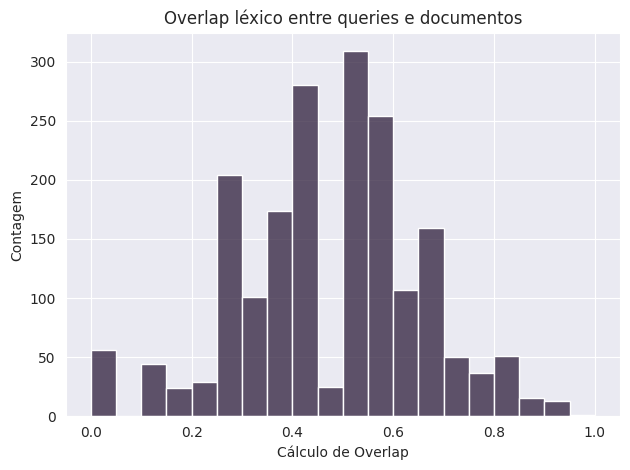

In [39]:
qrels_df["overlap"] = qrels_df.apply(lambda r: lexical_overlap(r["query_text"], r["doc_text"]), axis=1)

ax =sns.histplot(qrels_df["overlap"], bins=20)
plt.title("Overlap léxico entre queries e documentos")
ax.set_xlabel("Cálculo de Overlap")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()


## Guardando dados limpos
Com os dados limpos, podemos prosseguir para a etapa de preparação dos dados para a modelagem prevista. Para isso, apenas os dados necessários serão exportados em formato `parquet`, ou seja, os textos limpos (`clean_passage`, `clean_query`) e o score de relevância com a relação entre os textos (`score`).

In [41]:
# Exporting passages
# Rename column
passages_df["passage"] = passages_df["clean_passage"]

passages_df[["passage_id", "passage"]].to_parquet("./cleaned_passages.parquet")

In [42]:
# Exporting topics
# Rename column
topics_df["query"] = topics_df["clean_query"]

topics_df[["query_id", "query"]].to_parquet("./cleaned_topics.parquet")

In [43]:
# Exporting qrels
qrels_df[["query_id", "passage_id", "score"]].to_parquet("./cleaned_qrels.parquet")